<a href="https://colab.research.google.com/github/MohammedNasserAhmed/MHIP/blob/master/MHIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset

To get the dataset used here follow link below :

Dataset Source: https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset


## Visualizing Data

https://seaborn.pydata.org/tutorial/axis_grids.html

https://blog.insightdatascience.com/data-visualization-in-python-advanced-functionality-in-seaborn-20d217f1a9a6


In [1]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = [
                      "pip install sklearn",
                      "pip install scikit-learn",
                      "pip install plotly",
                      "pip install statsmodels",
                      "pip install panel",
                      "pip install colorama"
                    ]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

Preparing metadata (setup.py): started
Preparing metadata (setup.py): finished with status 'done'
Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2951 sha256=a385e6d314c572337964e67b7db2d250e9ab54df1c5a1a9198eefbfcdc39d1c2
Stored in directory: /root/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [43]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
import panel as pn
from colorama import Fore, Style, Back
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import pickle
from tabulate import tabulate
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn import tree


### Display Settings

In [4]:
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format
pal = ['#C060A1', '#46C2CB', '#ECB365','#FF0000','#0039A6','#414A4C']
plt.rcParams['figure.figsize'] = (8, 4)

### Backup Functions

In [5]:
# Define CSS styling
css = """
<style>
    table {
        width: 50%;
        text-align: center;
        'font-size': '12pt';

    }
    th, td {
        padding: 8px;
        text-align:center;
    }
    th {
        background-color: lightblue;
        color: black;

    }
    td {
        text-align:center!important;
        background-color: white;
        color: black;
    }
    td::after {
			content: attr(data-value ":.2f");
            }
</style>
"""
def Display(func, index=False, cells_colors =False):
    # to remove 0's decimals and set decimals to 2 only
    func = func.applymap(lambda x: "{:.2f}".format(x).rstrip('0').rstrip('.') if isinstance(x, float) else x)
    styled_df = HTML(css + func.to_html(index=index))
    display(styled_df)


def transform_series(data, variable, window, sigma):
    ''' Calculates the rolling average and the outliers '''
    avg = data[variable].rolling(window=window).mean()
    residual = data[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = np.abs(residual) > std * sigma
    return avg, avg[outliers]

## [ 1 ] Dataset

#### **Introduction**

The dataset used in this section is the insurance.csv dataset, which contains 1338 observations and 7 features. The features are:

* Independet Features :
 1. Age: Age of the customer.
 2. BMI: Body Mass Index of the individual.
 3. Children: Number of children individual has.
 4. Smoker: Is that individual a smoker or not.
 5. Region: Which region/part individual lives in.

* Dependent Feature
 6. Charges: The charges column is our target/independent feature.

The dataset contains 4 numerical features (age, BMI, children, and charges) and 3 categorical features (smoker, region, and charges). The goal is to use this dataset to predict the insurance charges of individuals.


#### **TO-DO List**

* Load the dataset
* Get the dimensionality (no. of features (columns) and observations(rows))
* DTypes and names of features
* Descriptive statistics (Max, min, mean, median and std for each continuous feature)
* Declare the target variable (feature)


**[ 1 : 1 ] Load the Dataset**

In [6]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab_Notebooks/Medical Health Insurance Cost Prediction /us_insurance.csv')
### Top 5 observations
print(Fore.WHITE + Back.LIGHTBLACK_EX + Style.BRIGHT + "The Top 5 oservations of Dataset : \n" + Style.RESET_ALL)
Display(df.head())
print(Fore.WHITE + Back.LIGHTBLACK_EX + Style.BRIGHT + "\n\n The Tail 5 oservations of Dataset : \n" + Style.RESET_ALL)
# Tail 5 observations
Display(df.tail())

The Top 5 oservations of Dataset : 



age,sex,bmi,children,smoker,region,charges
19,female,27.9,0,yes,southwest,16884.92
18,male,33.77,1,no,southeast,1725.55
28,male,33,3,no,southeast,4449.46
33,male,22.7,0,no,northwest,21984.47
32,male,28.88,0,no,northwest,3866.86




 The Tail 5 oservations of Dataset : 



age,sex,bmi,children,smoker,region,charges
50,male,30.97,3,no,northwest,10600.55
18,female,31.92,0,no,northeast,2205.98
18,female,36.85,0,no,southeast,1629.83
21,female,25.8,0,no,southwest,2007.94
61,female,29.07,0,yes,northwest,29141.36


**[ 1 : 2 ] Get the dimensionality**

In [7]:
print(Fore.BLUE + Style.BRIGHT +
      f"The no. of observations :"+
      Fore.LIGHTRED_EX +
      f"{len(df)} \n\n" +
      Fore.BLUE +
      "The no. of features :"+
      Fore.LIGHTRED_EX +
      f"{len(df.columns)}\n\n" +
      Fore.BLUE +
      "The Dataset shape is : " +
      Fore.LIGHTRED_EX +
      f"{df.shape}"
      + Style.RESET_ALL)


The no. of observations :1338 

The no. of features :7

The Dataset shape is : (1338, 7)


**[ 1 : 3 ] DTypes and names of features**

In [8]:
for col in df.columns.tolist():
    print(Fore.BLUE + Style.BRIGHT +
      "The feature name and dtype | "+ Fore.GREEN + f"{col} --> {df[col].dtype}"
      + Style.RESET_ALL)

features =  [name.replace("'", "") for name in df.columns.tolist()]
cat_features = df.select_dtypes(include=['object', 'category']).columns.to_list()
num_features =  df.drop(columns=cat_features).columns.tolist()

print(Style.BRIGHT + f"\n\nThe dataset features : " +
      Fore.MAGENTA + f"{', '.join(features)} \n" +
      Fore.BLACK + "The categorical features : " +
      Fore.MAGENTA + f"{', '.join(cat_features)}"+
      Fore.BLACK + "\nThe continuous features : " +
      Fore.MAGENTA + f"{', '.join(num_features)}"+
      Style.RESET_ALL)


The feature name and dtype | age --> int64
The feature name and dtype | sex --> object
The feature name and dtype | bmi --> float64
The feature name and dtype | children --> int64
The feature name and dtype | smoker --> object
The feature name and dtype | region --> object
The feature name and dtype | charges --> float64


The dataset features : age, sex, bmi, children, smoker, region, charges 
The categorical features : sex, smoker, region
The continuous features : age, bmi, children, charges


**[ 1 : 4 ] Descriptive Statistics**

In [9]:
print(Style.BRIGHT+Back.LIGHTBLACK_EX+ Fore.WHITE +
      "The Continuous Variables (features) \n" +
      Style.RESET_ALL)
Display(df.describe(), index=True)
print(Style.BRIGHT+ Fore.WHITE + Back.LIGHTBLACK_EX+
      "\nThe Categorical Variables (features) \n" +
      Style.RESET_ALL)
Display(df.describe(include="object"), index=True)

The Continuous Variables (features) 



,age,bmi,children,charges
count,1338,1338,1338,1338
mean,39.21,30.66,1.09,13270.42
std,14.05,6.1,1.21,12110.01
min,18,15.96,0,1121.87
25%,27,26.3,0,4740.29
50%,39,30.4,1,9382.03
75%,51,34.69,2,16639.91
max,64,53.13,5,63770.43



The Categorical Variables (features) 



,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [10]:
# Get the max min charges in the dataset
max_row_index = df['charges'].idxmax()
min_row_index = df['charges'].idxmin()

# Get both observations into a dataframe
max_min = pd.concat([df.loc[max_row_index], df.loc[min_row_index]], axis=1)

# set column headers
max_min.columns = ["The Highest Chrages","The Lowest Chrages"]

# print the row
Display(max_min, index=True)


,The Highest Chrages,The Lowest Chrages
age,54,18
sex,female,male
bmi,47.41,23.21
children,0,0
smoker,yes,no
region,southeast,southeast
charges,63770.43,1121.87


**Insights :**
You can see the notable differences in charges as well as in other features like Age, BMI, and Smoker by looking at the above table. I think these features play a significant role in determining insurance charges, as they directly affect the risk and potential costs associated with providing coverage. The person with the highest rate of charges is a smoker, 54 years old, and has a 47 BMI ( that means he's obese; according to the World Health Organization (WHO), a BMI of less than 18.5 is considered underweight, a BMI between 18.5 and 24.9 is considered normal weight, a BMI between 25 and 29.9 is considered overweight, and a BMI of 30 or higher is considered obese), while the individual with lower insurance charges looks younger, smokes less, and has a healthier lifestyle overall.

**[ 1 : 5 ] Declare the target variable (feature)**

***Target Variable*** : is the variable that the model is trying to predict or estimate. It is also known as the dependent variable or response variable. In regression models like this, the target variable is typically a continuous variable, such as a numeric value or a real number, and the goal is to find a relationship between the target variable and one or more predictor variables, also known as independent variables or features.

***The purpose of model*** is to predict the insurance ***chrages*** (target variable) by using some predictor variables *( age, sex, bmi, children, smoker, region )*

In [11]:
charges_stats = df['charges'].agg(['max', 'min', 'mean']).apply(lambda x: '{:.2f}'.format(x))

print(Style.BRIGHT + f"\nThe maximum Charges : " +
      Fore.GREEN + f"{charges_stats[0]} $" +
      Fore.BLACK + "\n\nThe minimum Charges : " +
      Fore.MAGENTA + f"{charges_stats[1]} $"+
      Fore.BLACK + "\n\nThe average of Charges : " +
      Fore.RED + f"{charges_stats[2]} $"+
      Style.RESET_ALL)


The maximum Charges : 63770.43 $

The minimum Charges : 1121.87 $

The average of Charges : 13270.42 $


# **Expolatory Data Analysis (EDA)**


EDA is an essential step in regression modeling that involves understanding the distribution of variables and identifying relationships. Various visualization libraries like seaborn, matplotlib, and plotly are used to create different plots and graphs to gain insights into the datase . Some significant questions to ask and answer during the EDA process for a health insurance prediction project with the given dataset include:

1. What is the distribution of the target variable (charges)?

2. What is the distribution of each attribute in the dataset, including age, sex, BMI, children, region, and smoker status?

3. Are there any missing or null values in the dataset? If so, how are they distributed across the attributes?

4. What is the correlation between each attribute and the target variable (charges)? Which attributes have the strongest correlation with the target variable?

5. Are there any significant differences in the distribution and correlation of the attributes based on different categories or subgroups (e.g., age, sex, smoker status, region)?

6. Are there any outliers in the dataset? If so, how do they affect the distribution and correlation of the attributes?

7. What insights can be gained from visualizing the data using scatter plots, histograms, box plots, and other visualization techniques?

8. Are there any significant interactions between the attributes that affect the prediction of the target variable?

Answering these questions can help to identify patterns, trends, and relationships in the data, and can provide valuable insights for feature engineering and model selection.

**Distribuation of Target Variable (chargs)**

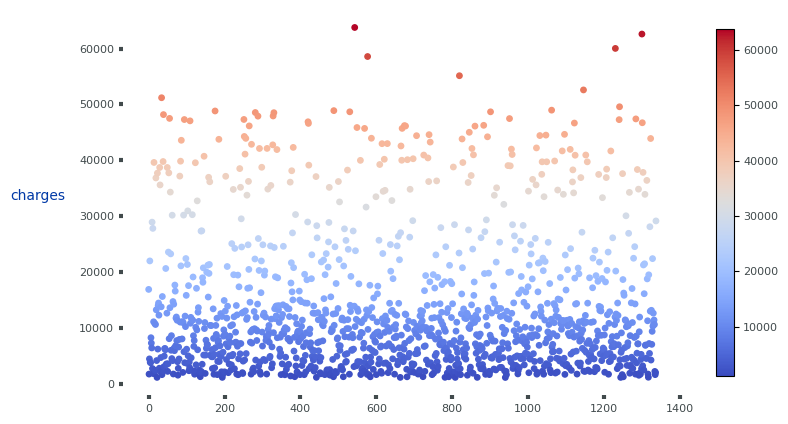

In [12]:
plt.figure(figsize=(9, 5))
plt.scatter(df.index, df['charges'], c = df['charges'], cmap='coolwarm', s=15)
cbar = plt.colorbar(pad=0.05,shrink=0.9)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(8)
     t.set_color("#414A4C")
ax= plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0)
ax.set_ylabel('charges', fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

plt.show()

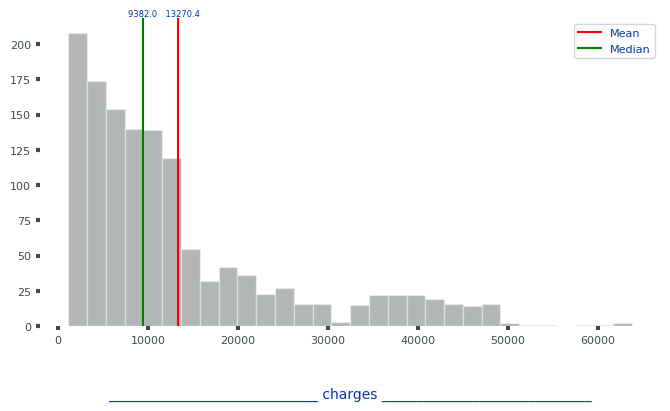

In [13]:
plt.rcParams['font.size'] = 8
plt.rcParams['text.color'] = '#0039A6'
plt.figure(figsize=(8, 4))
sns.distplot(df['charges'], kde=False,color='#414A4C', hist_kws={'edgecolor': 'white'})
plt.axvline(x=np.mean(df['charges']), color = 'red', label='Mean',)
plt.text(np.mean(df['charges']), plt.ylim()[1], f"    {np.mean(df['charges']):.1f}", ha='center', va='bottom', size=6)
plt.text(np.mean(df['charges']), plt.ylim()[1], f"{np.median(df['charges']):.1f}        ", ha='right', va='bottom', size=6)

plt.axvline(x=np.median(df['charges']), color = 'green', label='Median')
plt.legend(loc="upper right")
ax= plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0)
ax.set_xlabel('______________________________ charges ______________________________', fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)
plt.show()

**Target Variable Vs. Independent Variables**

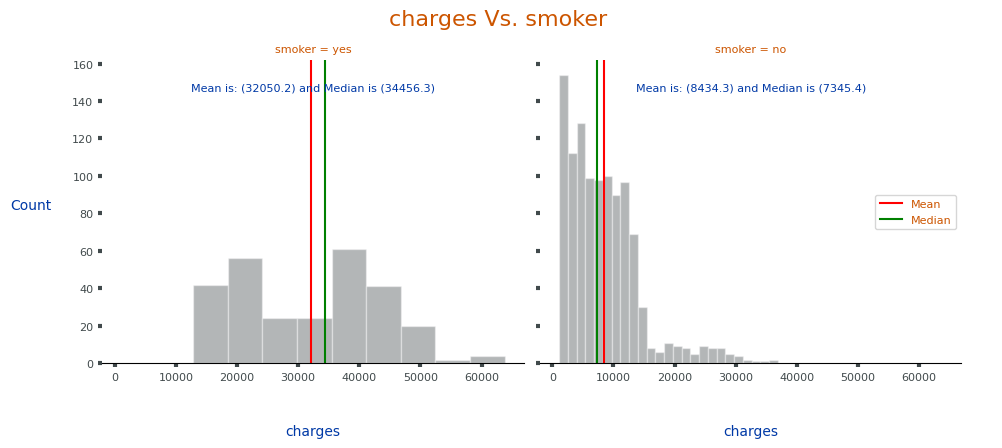

In [14]:
plt.rcParams['font.size'] = 8
plt.rcParams['text.color'] = '#CC5500'
def create_plot(data, var_1="smoker", var_2 = "charges", metrics=True, metrics_size= 8):

    g = sns.FacetGrid(data, col=var_1)

    g.add_legend()
    g.legend.get_title().set_fontsize(30)
    g.fig.set_size_inches(10, 4.5)

    g.fig.suptitle(f'{var_2} Vs. {var_1}', fontsize=16, color ="#CC5500")

    for ax in g.axes.flat:
        ax.set_xlabel(var_2, fontsize=10, color='#0039A6', labelpad=30)
        ax.set_ylabel('Count', fontsize=10, color='#0039A6', rotation = 360, labelpad=30)
        ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)
        ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)
    g.map(sns.distplot, var_2, color='#414A4C', kde=False,hist_kws={'edgecolor': 'white'})

    if metrics == True:
        for category, ax in g.axes_dict.items():
            # Get the count of each level
            mean = df[df[var_1] == category][var_2].mean()
            median = df[df[var_1] == category][var_2].median()
            ax.axvline(x=mean, color = 'red', label='Mean')
            ax.axvline(x=median, color = 'green', label='Median')

            ax.text(0.5, 0.9, f"Mean is: ({mean :.1f}) and Median is ({median :.1f})",
                transform=ax.transAxes, ha='center', color="#0039A6", size = metrics_size)
        plt.legend(loc="center right")
    for ax in g.axes.flat:
        ax.spines['left'].set_visible(False)

    return  plt.show()
create_plot(df)

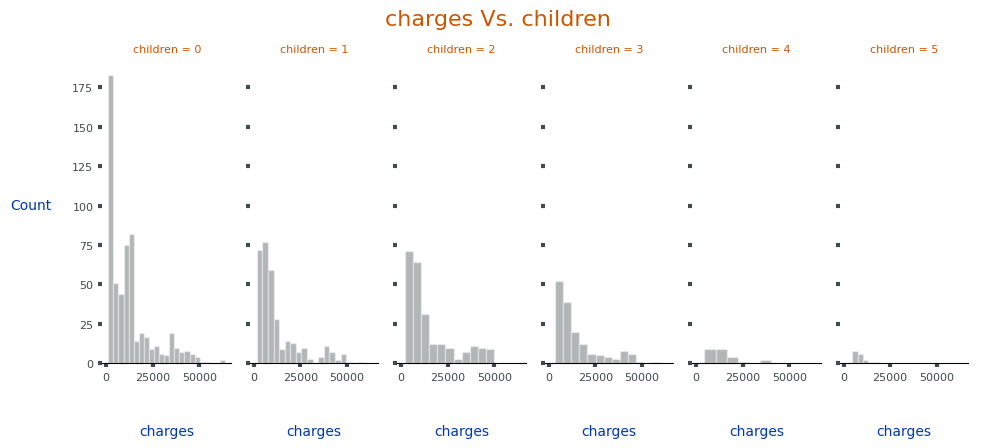

In [15]:
#sns.scatterplot(x='children', y='charges', data=df)
create_plot(data=df,var_1='children', metrics = False, metrics_size = 4)

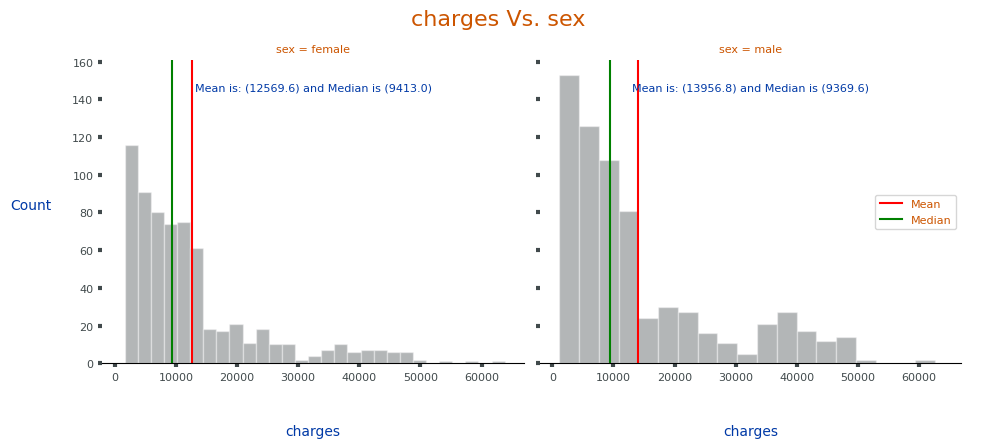

In [16]:
create_plot(data=df,var_1='sex', metrics = True)

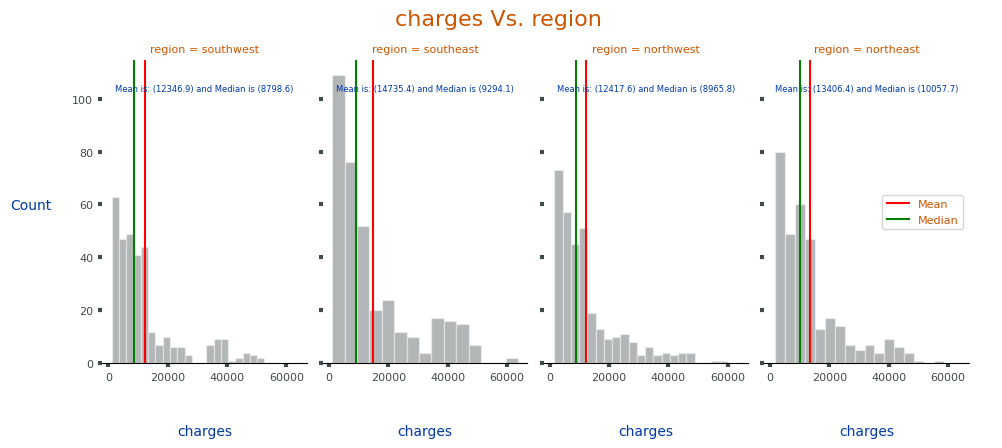

In [17]:
create_plot(data=df,var_1='region', metrics = True, metrics_size=6)

In [18]:
def bivariate_plot(data, hue, var):
    g = sns.FacetGrid(data, hue=hue, palette=pal,hue_kws={'marker': ['o', 's', 'D','v','^','*']}, height=5)
    g.fig.set_size_inches(8, 5)
    g.fig.suptitle(f'Charges Vs. {var} Vs. {hue}', fontsize=16, color ="#CC5500")
    for ax in g.axes.flat:
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_ylabel(var, fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
        ax.set_xlabel('charges', fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
        ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
        ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)
    g.map(sns.scatterplot, "charges", var, s=50, alpha=.7)
    g.add_legend()
    plt.show()

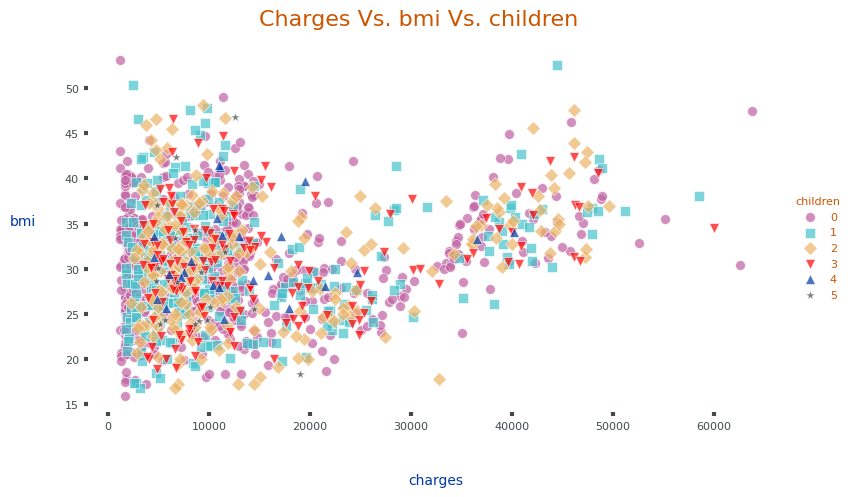

In [19]:
bivariate_plot(df, hue='children', var = "bmi")

In [20]:
def barplot(data, var, hue):
    plt.rcParams['font.size'] = 8

    g = sns.barplot(data = data, x = var, y = 'charges', hue = hue, palette =pal, width=0.6)
    #g.fig.suptitle()
    g.set_title(f' charges Vs. {var}  (Hue : {hue})', fontsize=12, color ="#CC5500",  y=1.1)
    fig = plt.gcf()

    ax = plt.gca()
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.1, 0.9))
    fig.set_figwidth(8)
    fig.set_figheight(4)
    for spine in ax.spines.values():
        spine.set_linewidth(0)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel("charges", fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
    ax.set_xlabel(var, fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
    ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)
    ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)
    v = 0
    h = 0
    for i,p in enumerate(ax.patches):
        cat = df[df[var] == df[var].unique().tolist()[v]][hue].value_counts()[h]
        total = len(df[df[var] == df[var].unique().tolist()[v]])
        precentage = "{:.2f} %".format((100 * cat)/total)
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,  height + 0.1 * height, precentage, ha="center",fontsize=6, color ='#0039A6')
        v+=1
        if v >= df[var].nunique():
            v=0
            h+=1


    plt.setp(ax.get_legend().get_texts(), fontsize='6', fontweight='bold', color="#0039A6")
    plt.setp(ax.get_legend().get_title(), fontsize='8',  color="#CC5500")
    plt.show()
    plt.show()


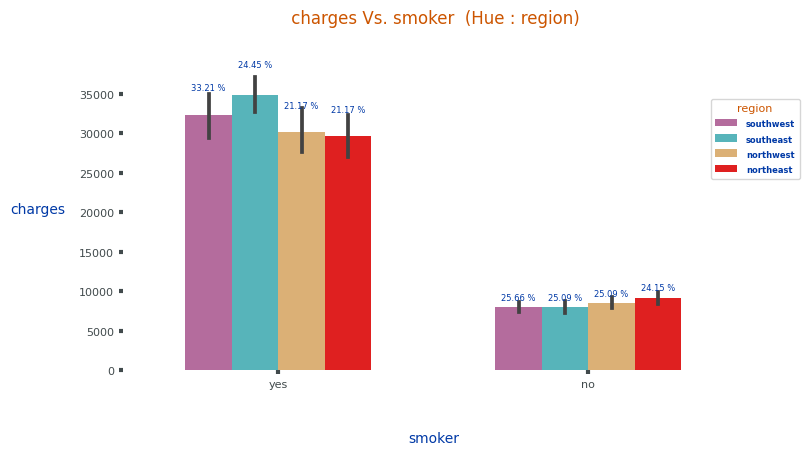

In [21]:
barplot(df, "smoker","region")

In [22]:
import plotly.express as px
fig = px.scatter(df, x="age", y="charges", log_x=True, color='sex')
fig.update_traces(hovertemplate='BMI: %{x} <br>Charges: %{y}') #
fig.update_traces(hovertemplate=None, selector={'name':'region'}) # revert to default hover
fig.show()

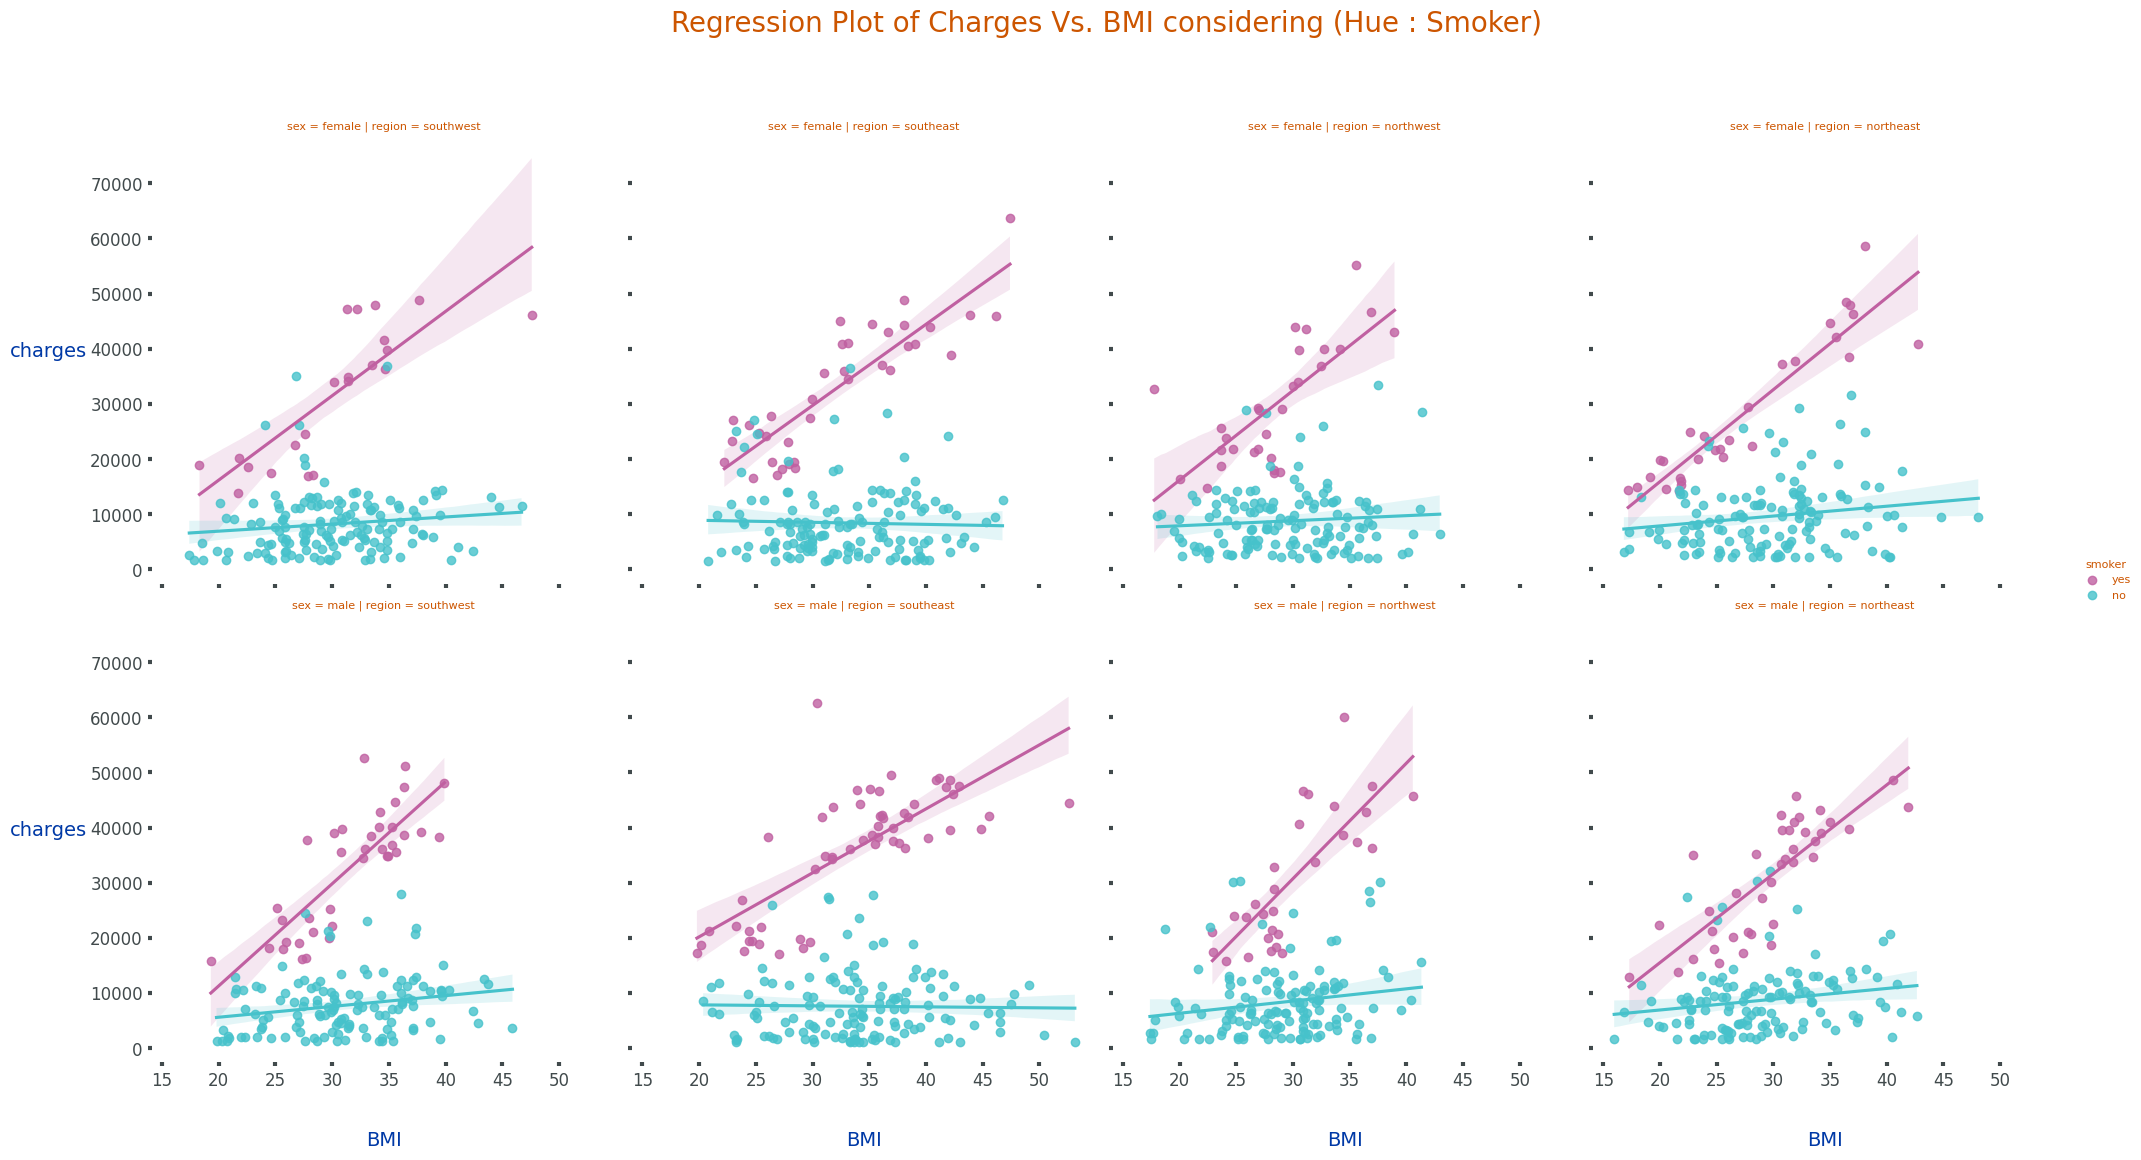

In [23]:
#regression plot to understand the relationship between the bmi and charges considering
g = sns.lmplot(x = "bmi", y = "charges", row = "sex", col = "region", hue = 'smoker', data = df, palette=pal)
g.fig.suptitle(f'Regression Plot of Charges Vs. BMI considering (Hue : Smoker)', fontsize=20, color ="#CC5500",  y=1.1)

for ax in g.axes.flat:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel("charges", fontsize=14, rotation=360, labelpad=30, color = "#0039A6")
    ax.set_xlabel('BMI', fontsize=14, rotation=360, labelpad=30, color = "#0039A6")
    ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=12)
    ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=12)
plt.show()

### Panel Board

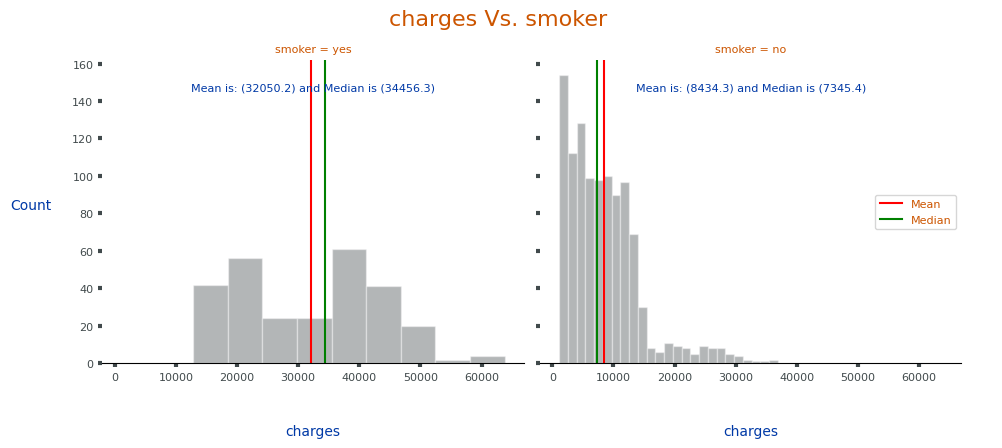

Column(design=<class 'panel.theme.materi...)
    [0] Select(design=<class 'panel.theme.materi..., name='categorical variables', options=['sex', 'smoker', ...], value='smoker')
    [1] Select(design=<class 'panel.theme.materi..., name='continous variables', options=['age', 'bmi', ...], value='charges')
    [2] ParamFunction(function, _pane=Str, defer_load=False, design=<class 'panel.theme.materi...)

In [24]:
pn.extension(design='material')

variable_widget_1 = pn.widgets.Select(name="categorical variables", value="smoker", options=df.select_dtypes(include=['object', 'category']).columns.to_list())
variable_widget_2 = pn.widgets.Select(name="continous variables", value="charges", options=df.select_dtypes(exclude=['object', 'category']).columns.to_list())
bound_plot = pn.bind(create_plot,data=df, var_1=variable_widget_1, var_2=variable_widget_2)
app = pn.Column(variable_widget_1, variable_widget_2, bound_plot)

app

## **[ 3 ] Data Preparation and Cleansing**

**8-Step checklist**

* Missing Values :
* Dublicate and Low Variation Data
* Incorrect and Irrelevant Data
* Categorical Data
* Outliers
* Feature Scaling
* Feature Selection
* Validation Split

**Missing Values**

In [25]:
# check per total dataset
print(Style.BRIGHT +
      "Any NULL values : " +
      Fore.BLUE +
      f"{df.isnull().values.any()}\n" +
      Style.RESET_ALL)

# Check per column
print(Style.BRIGHT +
      "NULL values per feature \n" +
      Fore.GREEN +
      f"{df.isnull().sum().astype(int).to_string(index=True, header=False)} \n"+
      Style.RESET_ALL)

Any NULL values : False

NULL values per feature 
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0 



**Dublicated and low variance data**

In [26]:
# DUBLICATED data
dups = df.duplicated()
print(dups.any())
print(df[dups])

True
     age   sex   bmi  children smoker     region  charges
581   19  male 30.59         0     no  northwest 1,639.56


In [27]:
# LOW VARIANCE features

cv = df.std() / df.mean()

# Set your desired threshold for low CV
threshold_cv = 0.1  # Adjust this value based on your needs

# Detect low CV features
low_cv_features = cv[cv < threshold_cv].index
data_high_variance = df.drop(low_cv_features, axis=1)

print("Low Coefficient of Variation Features:")
print(low_cv_features)


# Visualize low variance features
plt.figure(figsize=(8, 4))

for feature in low_cv_features:
    plt.subplot(1, len(low_cv_features), low_cv_features.get_loc(feature) + 1)
    plt.hist(df[feature], bins=20)
    plt.title(f"Low Variance Feature: {feature}")

plt.tight_layout()
plt.show()

Low Coefficient of Variation Features:
Index([], dtype='object')


<Figure size 800x400 with 0 Axes>

**Incorrect and Irrelevant Data**

*Anomaly Detection Algorithms* :

 Isolation Forest model represents the anomaly score assigned to each data point in your dataset. Anomaly scores indicate how likely a data point is to be an outlier or anomaly. In the Isolation Forest algorithm, lower anomaly scores indicate a higher likelihood of being an anomaly. Anomaly scores usually range between -1 and 1, where values closer to -1 are considered more anomalous.

In [51]:
def get_dummies(data):
    categoricals = data.select_dtypes(include=['object']).columns
    # Loop through each categorical column and encode using factorize
    for col in categoricals:
        data[col],_ = pd.factorize(data[col])
    return data

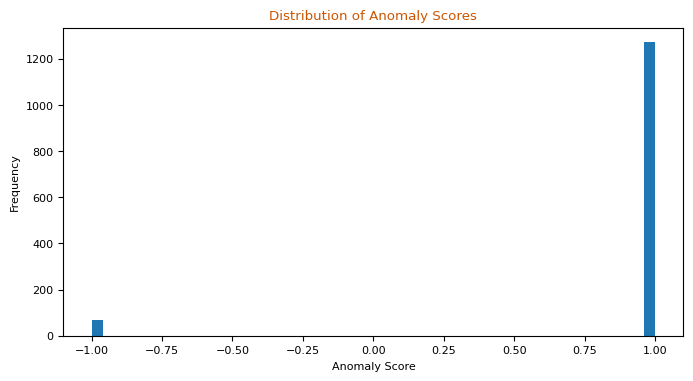

In [56]:
iso_ds = df.copy()

iso_ds = get_dummies(iso_ds)

iso_forest = IsolationForest(contamination=0.05)
anomaly_scores = iso_forest.fit_predict(iso_ds)

# Convert anomaly_scores to a Series
anomaly_scores_series = pd.Series(anomaly_scores, index=df.index)

# Filter out anomalies (rows with negative anomaly scores)
filtered_df = df[anomaly_scores_series >= 0]
filtered_df = filtered_df.reset_index(drop=True)

plt.hist(anomaly_scores, bins=50)
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.show()

**Categorical Data**

In [29]:
ds = df.copy()
def highlight_cols(col):
    color = 'red' if col.name in ["sex","region","smoker"] else 'black'
    return ['color: %s' % color]*len(col)

# Encode the Categorical Variabbles
for col in cat_features:
    array = pd.Categorical(ds[col])
    ds[col] = array.codes
ds.head().style.apply(highlight_cols, axis=0)


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900000,0,1,3,16884.924000
1,18,1,33.770000,1,0,2,1725.552300
2,28,1,33.000000,3,0,2,4449.462000
3,33,1,22.705000,0,0,1,21984.470610
4,32,1,28.880000,0,0,1,3866.855200


In [30]:
# Get percentages of Categorical variables
for col in cat_features:
    Display(pd.DataFrame((df[col].value_counts(normalize=True) * 100).apply(lambda x: "{:.2f}".format(x).rstrip('0').rstrip('.') + " %")), index=True)

,sex
male,50.52 %
female,49.48 %


,smoker
no,79.52 %
yes,20.48 %


,region
southeast,27.2 %
southwest,24.29 %
northwest,24.29 %
northeast,24.22 %


In [31]:
# Count observations per level for all categoricl features
for col in cat_features:
    Display(pd.DataFrame(pd.crosstab(index=df[col],columns = "freq").rename_axis(None, axis=1)), index=True)

,freq
sex,
female,662
male,676


,freq
smoker,
no,1064
yes,274


,freq
region,
northeast,324
northwest,325
southeast,364
southwest,325


***Insights*** : You can see that there are three categorical features in the dataset, which include sex (male or female), smoker (yes or no), and region (southeast, southwest, northeast, northwest). The male category in sex feature is top with 50.52% (676 males), the positive-smokers category is top with 79.52% (1067 positive-smokers), which looks imbalanced and may require more attention during analsis, and the southeast region is top with 27.2% (regions have roughly equal distributions as follows: southeast (27.20%), southwest (24.29%), northwest (24.29%), and northeast (24.20%)). These categorical features provide valuable insights into the demographics and lifestyle choices of the individuals in the dataset, allowing for further analysis and understanding of potential factors influencing insurance charges.

**Outliers**

*USING : Isolation Forest & Local Outlier Factor*

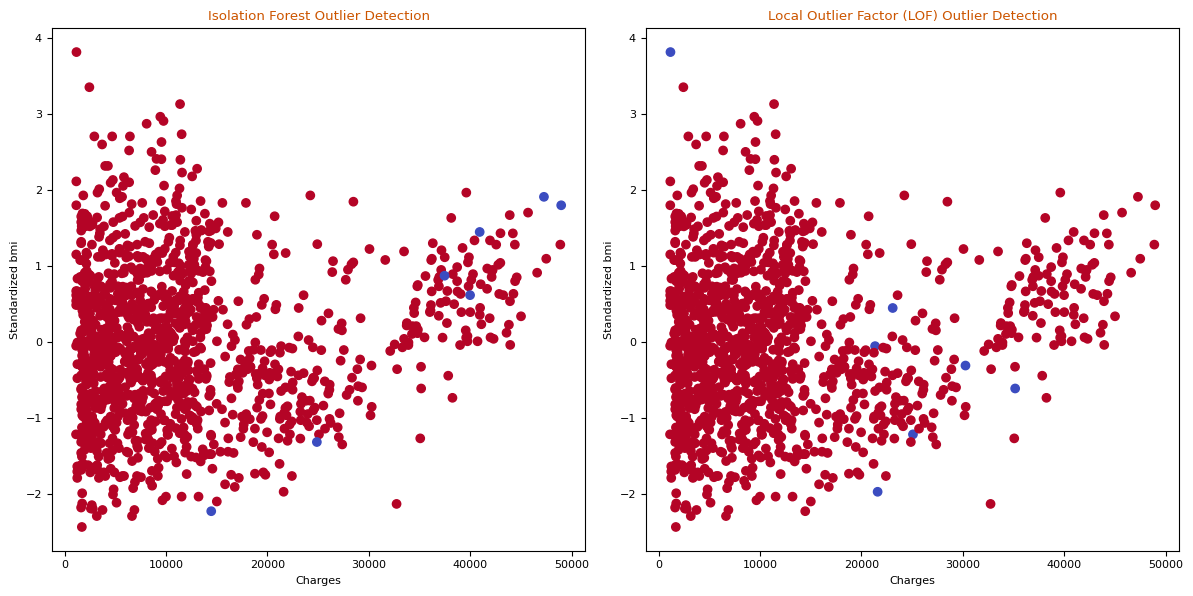

In [32]:
# Extract the charges column (target variable)
charges = iso_ds['charges'].values.reshape(-1, 1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dff)

# Apply Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.005)
iso_preds = iso_forest.fit_predict(X_scaled)

# Apply Local Outlier Factor (LOF) for outlier detection
lof = LocalOutlierFactor(contamination=0.005)
lof_preds = lof.fit_predict(X_scaled)

# Visualize the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(charges, X_scaled[:, 2], c=iso_preds, cmap='coolwarm')
plt.xlabel('Charges')
plt.ylabel('Standardized bmi')
plt.title('Isolation Forest Outlier Detection')

plt.subplot(1, 2, 2)
plt.scatter(charges, X_scaled[:, 2], c=lof_preds, cmap='coolwarm')
plt.xlabel('Charges')
plt.ylabel('Standardized bmi')
plt.title('Local Outlier Factor (LOF) Outlier Detection')

plt.tight_layout()
plt.show()


In [33]:
# Return outlier observations using Isolation Forest
iso_outliers = iso_ds[iso_preds == -1]
print("Outliers detected by Isolation Forest:")
print(iso_outliers)

# Return outlier observations using LOF
lof_outliers = iso_ds[lof_preds == -1]
print("Outliers detected by Local Outlier Factor:")
print(lof_outliers)

Outliers detected by Isolation Forest:
      age  sex   bmi  children  smoker  region   charges
301    53    0 22.61         3       0       3 24,873.38
412    26    0 17.20         2       0       3 14,455.64
558    35    0 34.10         3       0       2 39,983.43
725    30    0 39.05         3       0       1 40,932.43
1062   59    1 41.14         1       0       1 48,970.25
1186   20    1 35.62         3       0       2 37,465.34
1240   52    1 41.80         2       0       1 47,269.85
Outliers detected by Local Outlier Factor:
      age  sex   bmi  children  smoker  region   charges
102    18    0 30.11         0       1       3 21,344.85
115    60    1 28.59         0       1       3 30,260.00
219    24    0 23.21         0       1       1 25,081.77
242    55    0 26.80         1       1       0 35,160.13
430    19    1 33.10         0       1       0 23,082.96
1027   23    1 18.71         0       1       2 21,595.38
1317   18    1 53.13         0       1       1  1,163.46


In [34]:
data_cleaned_iso = filtered_df[iso_preds == 1]

# Remove outliers detected by Local Outlier Factor
data_cleaned_lof = filtered_df[lof_preds == 1]

print("Original Data before removing outliers:")
Display(df.describe(), index=True)

print("\n\nCleaned Data after removing Isolation Forest outliers:")
Display(data_cleaned_iso[num_features].describe(), index=True)

print("\n\nCleaned Data after removing Local Outlier Factor outliers:")
Display(data_cleaned_lof[num_features].describe(), index=True)



Original Data before removing outliers:


,age,bmi,children,charges
count,1338,1338,1338,1338
mean,39.21,30.66,1.09,13270.42
std,14.05,6.1,1.21,12110.01
min,18,15.96,0,1121.87
25%,27,26.3,0,4740.29
50%,39,30.4,1,9382.03
75%,51,34.69,2,16639.91
max,64,53.13,5,63770.43




Cleaned Data after removing Isolation Forest outliers:


,age,bmi,children,charges
count,1264,1264,1264,1264
mean,39.07,30.41,1.03,11897.57
std,13.87,5.93,1.14,10339.91
min,18,15.96,0,1121.87
25%,27,26.12,0,4528.9
50%,39,30.17,1,8881.15
75%,51,34.3,2,14255
max,64,53.13,5,48885.14




Cleaned Data after removing Local Outlier Factor outliers:


,age,bmi,children,charges
count,1264,1264,1264,1264
mean,39.12,30.43,1.04,11973.72
std,13.84,5.92,1.14,10476.95
min,18,15.96,0,1121.87
25%,27,26.12,0,4534.56
50%,39,30.2,1,8911.04
75%,51,34.34,2,14263.01
max,64,50.38,5,48970.25


*USING : TensorFlow  AutoEncoder*

42/42 [==============================] - 0s 1ms/step
Original Data before removing outliers:


,age,bmi,children,charges
count,1338,1338,1338,1338
mean,39.21,30.66,1.09,13270.42
std,14.05,6.1,1.21,12110.01
min,18,15.96,0,1121.87
25%,27,26.3,0,4740.29
50%,39,30.4,1,9382.03
75%,51,34.69,2,16639.91
max,64,53.13,5,63770.43




Cleaned Data after removing Autoencoder outliers:


,age,bmi,children,charges
count,1137,1137,1137,1137
mean,39.15,31.05,1.07,11670.93
std,14.06,5.94,1.2,11920.63
min,18,15.96,0,1121.87
25%,26,26.84,0,4260.74
50%,39,31,1,8027.97
75%,51,35.1,2,12269.69
max,64,52.58,5,52590.83


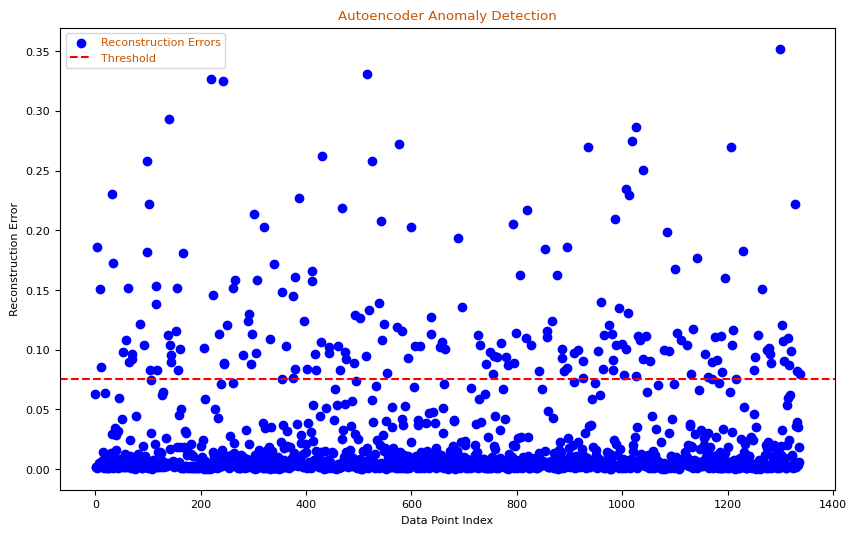

In [79]:
# Standardize the features
iso_ds = df.copy()
iso_ds = get_dummies(iso_ds)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(iso_ds)

# Build and train autoencoder for outlier detection
input_dim = X_scaled.shape[1]
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, verbose=0)

# Calculate reconstruction errors
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Define a threshold for outlier detection
threshold = np.percentile(reconstruction_errors, 85)

# Identify and remove outliers
outlier_indices = np.where(reconstruction_errors > threshold)[0]
data_cleaned_autoencoder = df.drop(outlier_indices)
data_cleaned_autoencoder = data_cleaned_autoencoder.reset_index(drop=True)

print("Original Data before removing outliers:")
Display(df.describe(), index=True)

print("\n\nCleaned Data after removing Autoencoder outliers:")
Display(data_cleaned_autoencoder[num_features].describe(), index=True)
print("\n\n")

# Plot reconstruction errors
plt.figure(figsize=(10, 6))
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, c='blue', marker='o', label='Reconstruction Errors')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.title('Autoencoder Anomaly Detection')
plt.legend()
plt.show()


**Feature Scaling**

✅ *Feature scaling* :

is an important step in the Exploratory Data Analysis (EDA) process, especially when working with machine learning algorithms that are sensitive to the scale of input features. In our case, we have a Medical Health Insurance dataset with predictors like age, BMI, sex, smoker, region, and children. Let's go through the feature scaling process and how it can be applied to our dataset:

Feature scaling is the process of standardizing the range of independent variables or features of the dataset. This is important because some machine learning algorithms, like gradient descent-based optimization, are sensitive to the scale of input features. Features with larger scales might dominate the learning process, leading to biased results.

**Feature Selection**

*USING ✴ Correlation with Random Forest Regressor*

In [36]:
# Separate features and target
X = iso_ds.drop('charges', axis=1)
y = iso_ds['charges']

# Calculate feature correlation with target
correlation = X.corrwith(y)

# Display correlation values
print(correlation)

# Train a Random Forest model for feature importance
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Display feature importances
print(feature_importances)


age         0.30
sex         0.06
bmi         0.20
children    0.07
smoker     -0.79
region      0.01
dtype: float64
[0.13121449 0.00603748 0.20907117 0.01975226 0.61990304 0.01402156]


*USING ✴ Correlation with heatmap*

<Axes: >

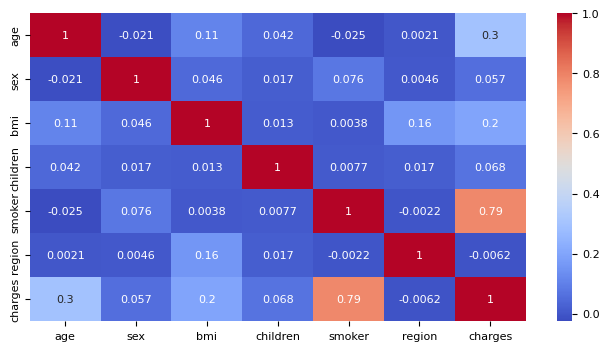

In [37]:
plt.figure(figsize=(8,4))
sns.heatmap(ds.corr(),cmap='coolwarm',annot=True)

***Insights***  ⏰   It looks like the target feature (charges) has a high correlation with the smoker feature in the US Medical Health Insurance Dataset and a low correlation with age and BMI features. This points out that smoking has the potential to be a significant factor in the underlying use case with a scale of 0.79, while age and BMI come next in terms of their impact on the target feature with a scale of 0.3 and 0.2, respectively. Other features like sex, children, and region have no detectable correlation with the target feature. These findings indicate that smoking has a strong influence on the charges. Age and BMI also have some influence, although to a lesser extent. However, factors such as sex, number of children, and region do not seem to have any noticeable impact on the target feature.

**Normalize and Split Data**

In [38]:
def set_seed(s=0):
    np.random.seed(s)

def dataset_split(dataset, minmax=False,  log = False):
    data = dataset.drop('charges', axis=1)
    target = dataset['charges']
    categorical_cols = data.select_dtypes(include=['object']).columns

    # Shuffle Data
    set_seed(0)
    Xy_perm = np.random.permutation(np.c_[data, target])
    X, y = Xy_perm[:,:-1], Xy_perm[:,-1]
    X = pd.DataFrame(X, columns=data.columns.tolist())
    data_num = X[['age', 'bmi', 'children']]  # Numerical variables
    data_cat = X.drop(['age', 'bmi', 'children'], axis=1)
    #Numerical Features
    #data_num = X[:, [0,2,3]].astype(np.float32, copy=False)
    if minmax:
        xmin, xmax = data_num.min(axis=0), data_num.max(axis=0)
        rng = (-1., 1.)
        df_num_scaled = (data_num - xmin) / (xmax - xmin) * (rng[1] - rng[0]) + rng[0]
    else:  # normalize
        mu, sigma = data_num.mean(axis=0), data_num.std(axis=0)
        df_num_scaled = (data_num - mu) / sigma
    # Categorical Features
    #cat_data = X[:, [1,4,5]].copy()
    ohe = OneHotEncoder(categories='auto')
    ohe.fit(data_cat)
    ohe_encoded = ohe.transform(data_cat)
    ohe_df = pd.DataFrame(ohe_encoded.toarray(), columns=ohe.get_feature_names_out(data_cat.columns))

    #X = np.c_[ohe_encoded.toarray(), df_num_scaled].astype(np.float32, copy=False)
    X = pd.concat([df_num_scaled, ohe_df], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X, y, X_train, X_test, y_train, y_test



In [45]:
def split(data, log = False):
    X = data.drop('charges', axis=1)
    if log:
        y = np.log10(data['charges'])
    else:
        y = data['charges']

    # Split features into numerical and categorical
    data_num = X[['age', 'bmi', 'children']]  # Numerical variables
    data_cat = X.drop(['age', 'bmi', 'children'], axis=1)  # Categorical variables

    # Scaling numerical variables
    scaler = StandardScaler()
    df_num_scaled = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)

    # One-hot encoding categorical variables
    encoder = OneHotEncoder(drop='first', sparse=False)
    data_cat_encoded = encoder.fit_transform(data_cat)
    df_cat_encoded = pd.DataFrame(data_cat_encoded, columns=encoder.get_feature_names_out(data_cat.columns))
    # Concatenate numerical and encoded categorical features
    X = pd.concat([df_num_scaled, df_cat_encoded], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X, y, X_train, X_test, y_train, y_test

*Split The Dataset*

In [80]:
X, y, X_train, X_test, y_train, y_test = split(data_cleaned_autoencoder)
print(X_train.shape, y_train.shape,
      X_test.shape, y_test.shape)


(909, 8) (909,) (228, 8) (228,)


## Models

In [81]:
#WE GET THE STATISTICAL MODEL
#add constant to predictor variables
x2 = sm.add_constant(np.asarray(X_train))
#fit linear regression model
model = sm.OLS(y_train, x2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     2478.
Date:                Thu, 31 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:30:49   Log-Likelihood:                -8382.7
No. Observations:                 909   AIC:                         1.678e+04
Df Residuals:                     900   BIC:                         1.683e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8054.2231    189.777     42.440      0.000    7681.766    8426.680
x1          4019.0804     82.389     48.782      0.000    3857.384    4180.776
x2           590.8738     87.969      6.717      0.000     418.225     763.522
x3           534.0124     83.179      6.420      0.000     370.766     697.259
x4          -130.2705    164.115     -0.794      0.428    -452.363     191.822
x5          3.174e+04    246.016    128.997      0.000    3.13e+04    3.22e+04
x6          -895.6179    236.495     -3.787      0.000   -1359.764    -431.472
x7          -858.6226    236.485     -3.631      0.000   -1322.748    -394.497
x8          -986.2169    235.002     -4.197      0.000   -1447.433    -525.000
==============================================================================
Omnibus:                      368.879   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13651.351
Skew:                          -1.156   Prob(JB):                         0.00
Kurtosis:                      21.844   Cond. No.                         5.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

+-----------------------------+----------+
|            Model            | Accuracy |
+-----------------------------+----------+
| Gradient Boosting Regressor |   0.98   |
|      Bagging Regressor      |   0.97   |
|        XGB Regressor        |   0.97   |
|   Random Forest Regressor   |   0.97   |
|     Ada Boost Regressor     |   0.96   |
+-----------------------------+----------+


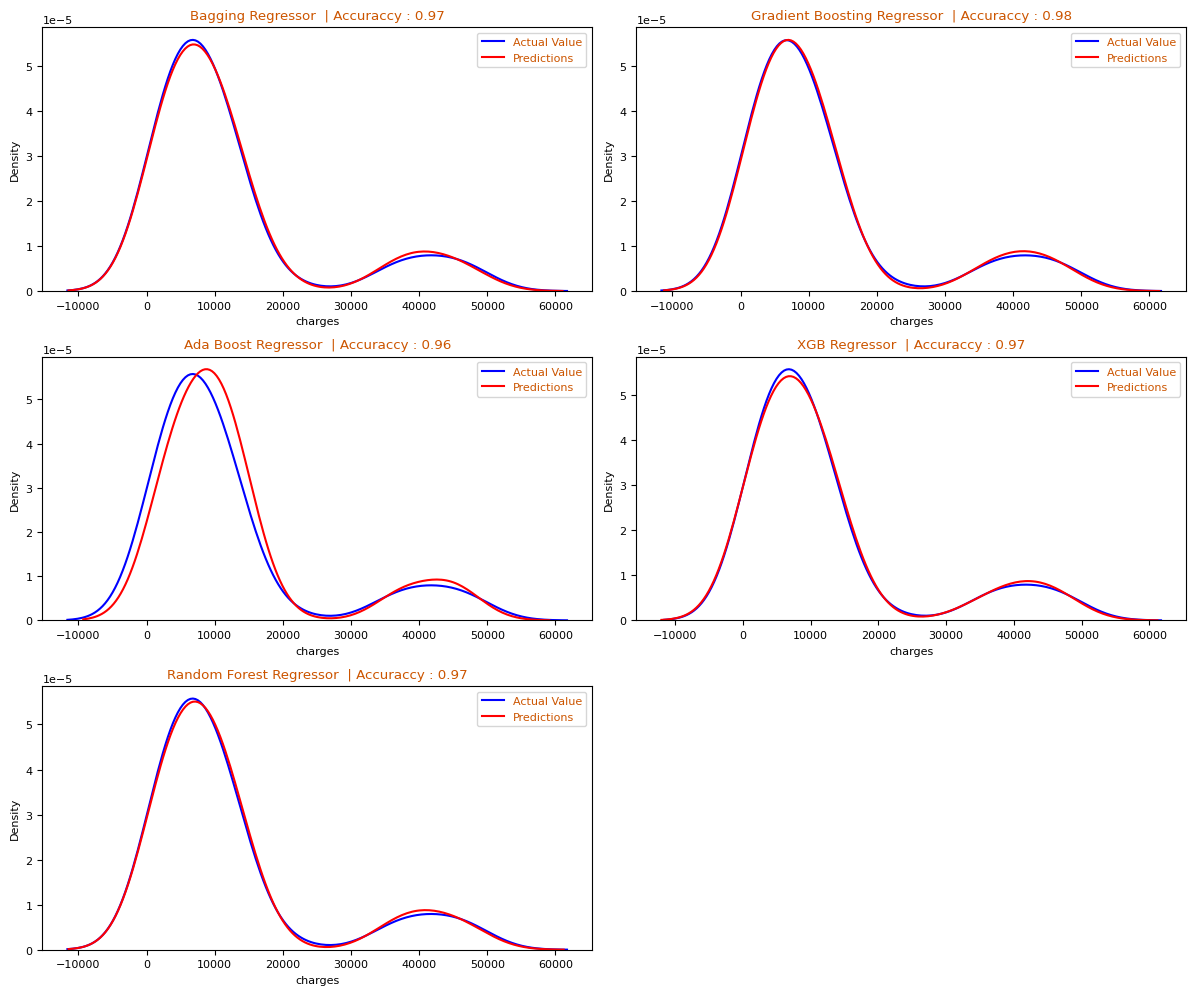

In [84]:
models = [
    ("Bagging Regressor", BaggingRegressor(tree.DecisionTreeRegressor(random_state=1))),
    ("Gradient Boosting Regressor",GradientBoostingRegressor()),
    ("Ada Boost Regressor",AdaBoostRegressor()),
    ("XGB Regressor",xgb.XGBRegressor()),
    ("Random Forest Regressor",RandomForestRegressor(n_estimators=100, criterion='squared_error',
min_samples_split=2))



    # Add more models here
]

# Train and evaluate models
results, preds = [], []
for model_name, model in models:
    model.fit(X_train, y_train)
    accuracy = model.score(X_test,y_test)
    predictions = model.predict(X_test)
    #accuracy = accuracy_score(y_test, predictions)
    preds.append([model_name,model, "{:.2f}".format(accuracy), predictions])
    results.append([model_name, "{:.2f}".format(accuracy)])
results = sorted(results, key=lambda x: x[1], reverse=True)
# Display results in a table
table_headers = ["Model", "Accuracy"]
table = tabulate(results, headers=table_headers, tablefmt="pretty")
print(table)


num_plots = len(models)
num_rows = int(np.ceil(np.sqrt(num_plots)))
num_cols = int(np.ceil(num_plots / num_rows))

# Create subplots grid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 10))

# Plot predictions using subplots
for i, (model_name, model,accuracy, predictions) in enumerate(preds):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.distplot(y_test, hist=False, color="b", label="Actual Value", ax=ax)
    sns.distplot(predictions, hist=False, color="r", label="Predictions" , ax=ax)
    ax.set_title(f"{model_name}  | Accuraccy : {accuracy}")
    ax.legend()

# Remove empty subplots
for i in range(len(models), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig('models.png')
plt.show()

In [ ]:
# df=0.866  filtered = 0.786 lof =0.804 iso = 0.852 iso(0.005) = 0.83
model = RandomForestRegressor(n_estimators=100, criterion='squared_error',
min_samples_split=2)
# fit the regressor model
model.fit(X_train, y_train)
RandomForestRegressor()
print(model.score(X_test, y_test))

In [ ]:
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4',
align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()


In [ ]:
 # save the iris classification model as a pickle file
model_pkl_file = "gbr_for_mhip.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
#WE PREDICT OUR MODEL
y_pred1 = model.predict(X_test)
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred1, hist=False, color="b", label="Fitted Values" , ax=ax1)
plt.title('Actual vs Fitted Values for Charges')
plt.xlabel('Charges')
plt.ylabel('')
plt.show()
## ANOTHER PLOTTING TECHNIQUE
plt.figure(figsize=(10, 5))
# acutal values
plt.plot([i for i in range(len(y_test))],np.array(y_test), c='g', label="actual values")
# predicted values
plt.plot([i for i in range(len(y_test))],y_pred1, c='m',label="predicted values")
plt.legend()
plt.show()




## Models

https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/

### Model Evaluation
The performance of each regression model is evaluated using various metrics, including Mean Absolute
Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). The evaluation results
provide insights into the accuracy of the models in predicting insurance costs.

##### POLYNOMIAL REGRESSION


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred6))
print('Mean Square Error:', metrics.mean_squared_error(y_test, y_pred6))
print('Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_test,
y_pred6)))

From the model evaluation score, we can see that polynomial regression and the Random Forest
Regressor are performing well than the other models.

### **Key Insights**
1. Feature Importance: After analyzing the dataset, we found that the most influential factors
affecting medical insurance charges are whether the person is a smoker, their BMI (Body Mass
Index), and their age.
2. Smoking Impact: Smokers tend to have significantly higher medical insurance charges compared
to non-smokers. This is a crucial insight that highlights the importance of lifestyle choices on
healthcare costs.
3. Age and Charges: The age of an individual is positively correlated with insurance charges. Older
individuals tend to have higher medical costs, which is understandable given the increased
likelihood of health issues as age advances.
4. BMI Influence: Higher BMI values are associated with increased medical insurance charges. This
suggests that maintaining a healthy weight can positively impact healthcare costs.
5. Model Performance: We evaluated multiple regression models including Multiple Linear
Regression, LassoCV, RidgeCV, ElasticNet, Random Forest Regressor, and Polynomial Regression.
Among these, Polynomial Regression and Random Forest Regressor showed better performance
in predicting medical insurance charges.
6. Polynomial Model Advantage: The Polynomial Regression model showed the lowest Mean
Absolute Error, Mean Square Error, and Root Mean Square Error among all models, indicating its
capability to better capture the underlying patterns in the data.


### **Suggestions**

1. Promote Healthy Lifestyles: Encourage smoking cessation programs and awareness campaigns
to reduce the number of smokers. This could lead to substantial savings in healthcare costs.
2. Health Awareness: Run campaigns to educate people about the impact of BMI on health and
insurance costs. Promoting healthy eating and exercise can help individuals maintain a healthy
weight and potentially lower their medical expenses.
3. Targeted Insurance Plans: Design insurance plans that cater to different age groups. Tailored
plans can address the unique healthcare needs of people at various life stages.
4. Model Refinement: Continue refining and optimizing predictive models. This could involve
exploring more advanced algorithms or techniques to improve the accuracy of predictions.
5. Regular Data Updates: Regularly update the dataset with new data to ensure that the models
remain relevant and accurate. Healthcare trends and cost patterns may change over time.
6. Personalized Recommendations: Provide personalized recommendations to individuals based
on their age, smoking status, and BMI to help them make informed decisions about their
healthcare and insurance choices.
7. Collaboration with Healthcare Providers: Collaborate with healthcare providers to gather
more comprehensive data that includes detailed medical history. This could further enhance the
accuracy of predictive models.
8. Continuous Monitoring: Keep monitoring the performance of predictive models and update
them as necessary. New insights or changes in the healthcare landscape could require
adjustments to the models.
9. Customer Education: Educate customers about how their lifestyle choices and age can impact
their insurance costs. This transparency can help them make healthier decisions and potentially
reduce their expenses.
By implementing these insights and suggestions, the insurance industry can make informed decisions to
optimize insurance plans and promote healthier lifestyles among their customers.


## **Conclusion**
This project demonstrates the process of predicting medical health insurance costs using various
regression models. The models' performances are compared using evaluation metrics, and key insights
are drawn from the analysis. The project highlights the importance of data preprocessing, model
selection, and evaluation for accurate predictions in the field of medical insurance cost estimation.
Further improvements and refinements could be explored to enhance the models' predictive capabilities.